In [60]:
#Importing libraries and moduels 
import pickle
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import ml_pipeline.cleanse as cl
import ml_pipeline.feature_engineering as fe
import ml_pipeline.encode as enc

In [61]:
# Import data set and check 
path = "data/dirty_credit_data (1).csv"
data = pd.read_csv(path)
data.head()

,Age,Credit_Score,Education_Level,Employment_Status,Has_Dependents,Income,Loan_Purpose,Loan_Value,Married,Prior_Default,Sex,Wtd_Ave_Debt_Interest,Defaulted,Total_Debt
0,42.0,750.0,1,Full-Time,Y,24602.0,Mortgage,1513,Married,N,Male,0.0553,N,1521
1,34.7,679.0,2,Full-Time,N,54781.0,Credit Card,9003,Single,N,Male,0.1247,Y,9069
2,31.5,746.0,2,Full-Time,N,47840.0,Credit Card,7553,Single,N,Female,0.0721,N,7586
3,31.0,741.0,2,Part-Time,N,60266.0,Credit Card,11622,Single,N,Male,0.1132,N,11677
4,55.7,725.0,3,Full-Time,N,75325.0,Mortgage,13617,Single,N,Female,0.1410,N,13654


In [62]:
# Identify and split target 
# Removes data that have no target variable and drops dupes
# Ln tranformation if needed 
target = 'Defaulted'
data.dropna(subset = [target], inplace=True)
data.drop_duplicates(inplace=True)

In [63]:
# Train Test Split 
# Separate target from the rest of the data
# Note the random state for later 
cols = list(data.columns)
cols.remove(target)

# Define variables
y = data[target]
X = data[cols]

# Immediately train test split
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# Export 
training = pd.concat([x_tr, y_tr], axis=1, ignore_index=False)
output_path = "./data/ml_project_eda.csv"

training.to_csv(output_path, index=False)

In [64]:
#Pipeline time 
# Instantiate the pipeline steps list
    # This is going to be the "recipe" for the pipeline. Every step is a tuple that looks like: ("name", step_object)
    # step_object is going to have all the arguments we want to use already included. Ex: CastToCategory(variable = "req_date_qtr")
steps = [] 

# Instantiate pipeline (IngestAndPrepare always first)
steps.append(("Ingest and Prepare", cl.IngestAndPrepare()))

In [65]:
#Categorical or Numerical 
print(x_tr.columns) 


Index(['Age', 'Credit_Score', 'Education_Level', 'Employment_Status',
       'Has_Dependents', 'Income', 'Loan_Purpose', 'Loan_Value', 'Married',
       'Prior_Default', 'Sex', 'Wtd_Ave_Debt_Interest', 'Total_Debt'],
      dtype='str')


In [66]:
#Identify numeric or categorical
nums = ['age','credit_score','income','loan_value','total_debt','wtd_ave_debt_interest'] 

cats = ['employment_status','has_dependents','loan_purpose','married','prior_default','sex', 'education_level']

In [67]:
# Cast numeric to category where appropriate 
# we will have to change education level 
steps.append(("Cast education_level to cat", cl.CastToCategory('education_level')))

In [68]:
# Missing values 
# Categories that have missing values are credit score, employment status, loan purpose, married and income 
  
for n in nums:
    steps.append((f"Cast {n} missing vals to median", cl.ImputeMissingNumbers(n, 'median')))
    
for c in cats:
    steps.append((f"Cast {c} missing vals to mode",cl.ImputeMissingClasses(c, 'mode')))
    steps.append((f"Cast {c} classses to lower case",cl.CommonCaseClasses(c, 'lower')))


In [69]:
 #Rare Classes 
# Dropping Unemployed which makes up 0.05% of data 
steps.append(("Correct employment_status rare classes @ 05%", cl.HandleRareClasses('employment_status', threshold = 0.005)))


In [70]:
 
# Outliers
# Use this to clean data cl.ManualOutliers(column, threshold_value, side)
# If distribution is extreme we will do a ln transformation

# Age - No one older than 73 no younger than 17 
steps.append(("Handling outliers for  young age", cl.ManualOutliers('age', 17, 'left')))
steps.append(("Handling outliers for old age", cl.ManualOutliers('age', 73, 'right')))

# Credit Score - Must be between 300 and 850 
steps.append(("Cap credit_score upper", cl.ManualOutliers('credit_score', 850, 'right')))
steps.append(("Cap credit_score lower", cl.ManualOutliers('credit_score', 300, 'left'))) 

# Income - Has to be pos
steps.append(("Handling outliers for income", cl.ManualOutliers('income', 0, 'left')))

# Loan Value - Ln transformation 
# Total Debt - Has to be pos - ln transformation 
steps.append(("Handling outliers for total debt", cl.ManualOutliers('total_debt', 0, 'left')))


# Wtd Debt - Looks good 
# Education Level - Looks Goof 
# Employment Status - Misspelling
# Has Dependents - Looks good
# Loan Purpose - Misspellings 
# Married - Looks good 
# Prior Default - Look good 
# Sex - Misspellings 



In [71]:
# Compress Classes aka fix misspellings 
# Employment Status 
map_dict = {'prat-time':'part-time', 
            'pert-time': 'part-time'}
steps.append(("compressing employment_status", fe.CompressClasses('employment_status', map_dict))) 

# Sex 
map_dict = {'mail':'male',
            'femalee':'female'} 
steps.append(("compressing sex", fe.CompressClasses('sex', map_dict)))

# Loan Purpose 
map_dict = {'credit crad':'credit card',
            'bussins':'business',
            'mortgarage':'mortgage'} 
steps.append(("compressing loan_Purpose", fe.CompressClasses('loan_purpose', map_dict)))  


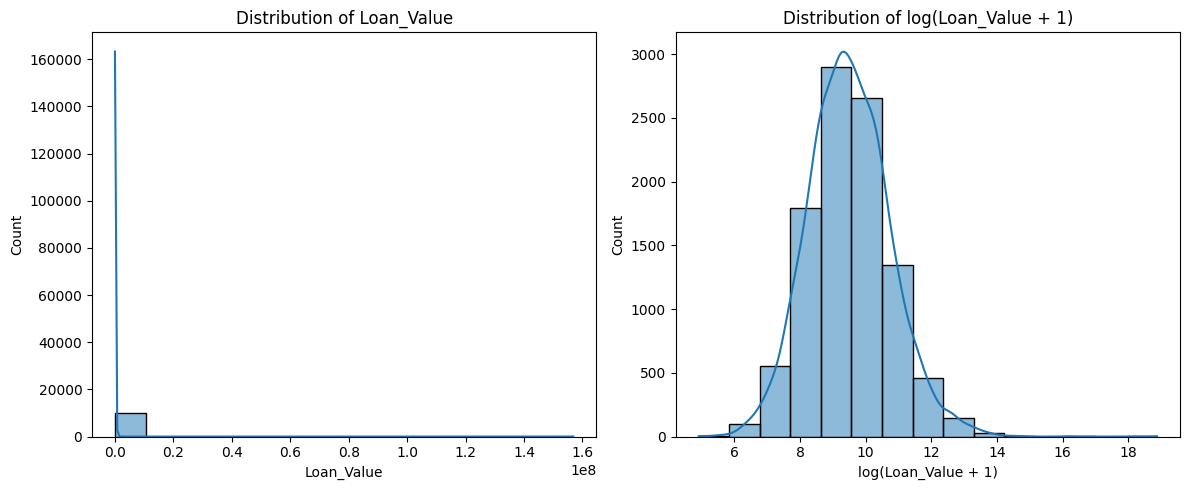

In [72]:
# Visualizing LN transformation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

var = 'Loan_Value' #

# Plot histogram for Total_Debt/Loan_Value
sns.histplot(data[var].dropna(), bins=15, kde=True, ax=axes[0])
axes[0].set_title(f'Distribution of {var}')
axes[0].set_xlabel(var)

# Plot histogram for log(Total_Debt+1)/log(Loan_Value+1)
sns.histplot(np.log(data[var].dropna() + 1), bins=15, kde=True, ax=axes[1])
axes[1].set_title(f'Distribution of log({var} + 1)')
axes[1].set_xlabel(f'log({var} + 1)')

plt.tight_layout()
plt.show()

In [73]:
# Numeric transformations (Ln, Power, Interact, Scalar)
    # LN Total_Debt 
steps.append(("Ln total_debt", fe.Ln('total_debt', drop_orig = True)))

    # LN Loan_Value 
steps.append(("Ln loan_value", fe.Ln('loan_value', drop_orig = True)))

In [74]:
# Drop variables
# Sex has 0 correlation to Defaulted so we will drop variables also help model not be biased 
steps.append(("remove sex", fe.DropVar('sex')))
cats.remove('sex') # pull from list of categorical variables (will need to do this for OneHotEncode)

In [75]:
#Encode 
steps.append(("OneHotEncoding", enc.OneHotEncode(cats)))

In [76]:
#Make Pipeline 
pipe = Pipeline(steps)

In [77]:
# fit and transform the training set
    # fit will store all our parameters for our various functions/calculate others based on the data
    # transform will actually execute the transformations
    # fit_transform will do both at the same time (us being lazy)
x_tr = pipe.fit_transform(x_tr)
assert len(x_tr) == len(y_tr), "Training set length mismatch!!!"
x_tr.head()

WARNING (Ln): total_debt contains values <= 0; implementing adjustment to make all values >= 1
WARNING (OneHotEncode): column 'employment_status' has new categories in transform data that were not seen during fit: {nan}. These will be encoded as all zeros (same as the dropped category '#Other').
WARNING (OneHotEncode): column 'loan_purpose' has new categories in transform data that were not seen during fit: {nan}. These will be encoded as all zeros (same as the dropped category 'medical').
WARNING (OneHotEncode): column 'married' has new categories in transform data that were not seen during fit: {nan}. These will be encoded as all zeros (same as the dropped category 'married').


,age,credit_score,income,wtd_ave_debt_interest,ln(total_debt),ln(loan_value),employment_status_full-time,employment_status_part-time,employment_status_unemployed,employment_status_full-tme,...,loan_purpose_credit_card,loan_purpose_auto,loan_purpose_business,loan_purpose_mortgage,married_single,prior_default_n,education_level_2,education_level_3,education_level_1,education_level_0
9069,35.9,690.0,105072.0,0.1457,10.476245,10.476273,0,1,0,0,...,1,0,0,0,1,1,1,0,0,0
2603,36.6,643.0,47074.0,0.1337,9.019664,9.028219,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
7738,46.3,740.0,54489.0,0.1041,8.470102,8.494129,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0
1579,54.7,737.0,131456.0,0.1269,11.850140,11.850176,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
5058,44.8,633.0,67539.0,0.1557,8.916506,8.913819,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0


In [78]:
# transform the test set (we've already fit all of our parameters... want to use those methods to transform test data)
x_te = pipe.transform(x_te)

WARNING (IngestAndPrepare): age has values greater than the maximum training value: 75.2. You will be extrapolating outside of the training data range.
WARNING (IngestAndPrepare): wtd_ave_debt_interest has values less than the minimum training value: 0.0279. You will be extrapolating outside of the training data range.
WARNING (OneHotEncode): column 'employment_status' has new categories in transform data that were not seen during fit: {nan}. These will be encoded as all zeros (same as the dropped category '#Other').
WARNING (OneHotEncode): column 'loan_purpose' has new categories in transform data that were not seen during fit: {nan}. These will be encoded as all zeros (same as the dropped category 'medical').
WARNING (OneHotEncode): column 'married' has new categories in transform data that were not seen during fit: {nan}. These will be encoded as all zeros (same as the dropped category 'married').


In [79]:
# Pickle and save the pipeline
with open("./pickles/data_pipeline.pickle", 'wb') as handle:
    pickle.dump(pipe, handle)

In [ ]:
# Pickle and save the model
with open("./pickles/data_pipeline.pickle", 'wb') as handle:
    pickle.dump(gbf_model, handle)